# Pathology prediction (fracture)

@References : Soenksen, L.R., Ma, Y., Zeng, C. et al. Integrated multimodal artificial intelligence framework for healthcare applications. npj Digit. Med. 5, 149 (2022). https://doi.org/10.1038/s41746-022-00689-4

In this notebook, the task is to predict the fracture pathology using the CSV embeddings file

## Introduction


Radiology notes were processed to determine if each of the pathologies was explicitly confirmed as present (value = 1), explicitly confirmed as absent (value = 0), inconclusive in the study (value = −1), or not explored (no value).

Selected samples :  0 or 1 values (removing the rest from the training and testing data).

Excluded variables : the unstructured radiology notes component (E_rad ) from the allowable input to avoid potential overfitting or misrepresentations of real predictive value. 

The model is based on binary classification for each target chest pathology.

Final sample size for the fracture pathology is : (N = 557)

#### Imports

In [2]:
import os
os.chdir('../')

from pandas import read_csv

from src.data import constants
from src.data.dataset import HAIMDataset
from src.evaluation.pycaret_evaluator import PyCaretEvaluator
from src.utils.metric_scores import *

#### Read data from local source



In [3]:
df = read_csv(constants.FILE_DF, nrows=constants.N_DATA)

#### Create a custom dataset for the HAIM experiment


Build the target column for the task at hand, set the dataset specificities:  the ``haim_id`` as a ``global_id``, use all sources except ``radiology notes`` 

In [4]:
dataset = HAIMDataset(df,  
                      constants.CHEST_PREDICTORS, 
                      constants.ALL_MODALITIES, 
                      constants.FRACTURE, 
                      constants.IMG_ID, 
                      constants.GLOBAL_ID)

#### Set hyper-parameters

In [5]:
# Define the grid oh hyper-parameters for the tuning
grid_hps = {'max_depth': [5, 6, 7, 8],
            'n_estimators': [200, 300],
            'learning_rate': [0.3, 0.1, 0.05],
            }

### Model training and predictions using an XGBClassifier model with GridSearchCV and Hyperparameters optimization


The goal of this section of the notebook is to compute the following metrics:

``ACCURACY_SCORE, BALANCED_ACCURACY_SCORE, SENSITIVITY, SPECIFICITY, AUC, BRIER SCORE, BINARY CROSS-ENTROPY``


The
hyperparameter combinations of individual XGBoost models were
selected within each training loop using a ``fivefold cross-validated
grid search`` on the training set (80%). This XGBoost ``tuning process``
selected the ``maximum depth of the trees (5–8)``, the number of
``estimators (200 or 300)``, and the ``learning rate (0.05, 0.1, 0.3)``
according to the parameter value combination leading to the
highest observed AUROC within the training loop 


As mentioned previously, all XGBoost models were trained ``five times with five different data splits`` to repeat the
experiments and compute average metrics 


```Refer to page 8 of study``` : https://doi.org/10.1038/s41746-022-00689-4

Outer fold 1/5
Configuring PyCaret for outer fold 1
Creating model xgboost for outer fold 1


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9583,0.8125,1.0000,0.9577,0.9784,0.3864,0.4893
1,0.9296,0.5364,1.0000,0.9296,0.9635,0.0000,0.0000
2,0.9296,0.7485,1.0000,0.9296,0.9635,0.0000,0.0000
3,0.9437,0.6697,1.0000,0.9429,0.9706,0.3173,0.4342
4,0.9437,0.6576,1.0000,0.9429,0.9706,0.3173,0.4342
Mean,0.9410,0.6849,1.0000,0.9405,0.9693,0.2042,0.2716
Std,0.0107,0.0931,0.0000,0.0105,0.0055,0.1686,0.2226


Tuning hyperparameters for model xgboost with custom grid


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9583,0.8125,1.0000,0.9577,0.9784,0.3864,0.4893
1,0.9296,0.5364,1.0000,0.9296,0.9635,0.0000,0.0000
2,0.9296,0.7485,1.0000,0.9296,0.9635,0.0000,0.0000
3,0.9437,0.6697,1.0000,0.9429,0.9706,0.3173,0.4342
4,0.9437,0.6576,1.0000,0.9429,0.9706,0.3173,0.4342
Mean,0.9410,0.6849,1.0000,0.9405,0.9693,0.2042,0.2716
Std,0.0107,0.0931,0.0000,0.0105,0.0055,0.1686,0.2226


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9821,0.9654,1.0000,0.9815,0.9907,0.7910,0.8089


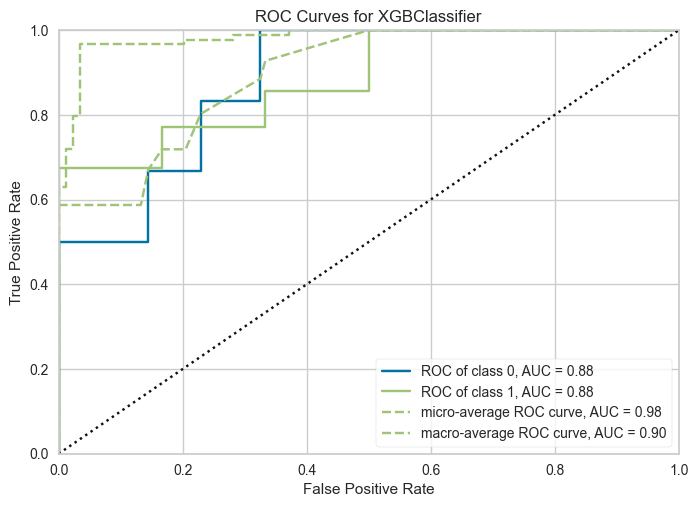

Outer fold 2/5
Configuring PyCaret for outer fold 2
Creating model xgboost for outer fold 2


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9583,0.8603,1.0000,0.9577,0.9784,0.3864,0.4893
1,0.9577,0.8030,1.0000,0.9565,0.9778,0.5535,0.6186
2,0.9296,0.3636,1.0000,0.9296,0.9635,0.0000,0.0000
3,0.9437,0.7727,1.0000,0.9429,0.9706,0.3173,0.4342
4,0.9437,0.8848,1.0000,0.9429,0.9706,0.3173,0.4342
Mean,0.9466,0.7369,1.0000,0.9459,0.9722,0.3149,0.3953
Std,0.0107,0.1908,0.0000,0.0104,0.0055,0.1796,0.2088


Tuning hyperparameters for model xgboost with custom grid


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9583,0.8272,1.0000,0.9577,0.9784,0.3864,0.4893
1,0.9577,0.7515,1.0000,0.9565,0.9778,0.5535,0.6186
2,0.9296,0.3697,1.0000,0.9296,0.9635,0.0000,0.0000
3,0.9577,0.7303,1.0000,0.9565,0.9778,0.5535,0.6186
4,0.9437,0.9152,1.0000,0.9429,0.9706,0.3173,0.4342
Mean,0.9494,0.7188,1.0000,0.9486,0.9736,0.3621,0.4321
Std,0.0114,0.1862,0.0000,0.0110,0.0058,0.2034,0.2278


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Transformation Pipeline and Model Successfully Saved


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9554,0.8726,1.0000,0.9550,0.9770,0.2746,0.3989


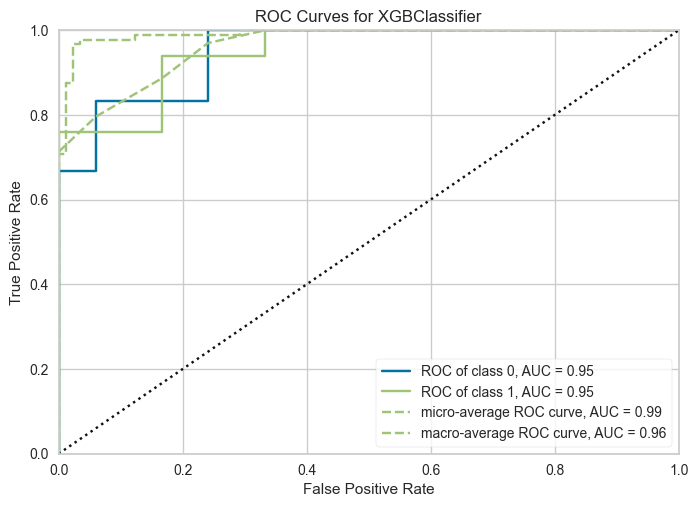

Outer fold 3/5
Configuring PyCaret for outer fold 3
Creating model xgboost for outer fold 3


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9583,0.6287,1.0000,0.9577,0.9784,0.3864,0.4893
1,0.9577,0.7727,1.0000,0.9565,0.9778,0.5535,0.6186
2,0.9437,0.5939,1.0000,0.9429,0.9706,0.3173,0.4342
3,0.9296,0.6576,1.0000,0.9296,0.9635,0.0000,0.0000
4,0.9437,0.8303,1.0000,0.9429,0.9706,0.3173,0.4342
Mean,0.9466,0.6966,1.0000,0.9459,0.9722,0.3149,0.3953
Std,0.0107,0.0898,0.0000,0.0104,0.0055,0.1796,0.2088


Tuning hyperparameters for model xgboost with custom grid


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9583,0.6287,1.0000,0.9577,0.9784,0.3864,0.4893
1,0.9577,0.7727,1.0000,0.9565,0.9778,0.5535,0.6186
2,0.9437,0.5939,1.0000,0.9429,0.9706,0.3173,0.4342
3,0.9296,0.6576,1.0000,0.9296,0.9635,0.0000,0.0000
4,0.9437,0.8303,1.0000,0.9429,0.9706,0.3173,0.4342
Mean,0.9466,0.6966,1.0000,0.9459,0.9722,0.3149,0.3953
Std,0.0107,0.0898,0.0000,0.0104,0.0055,0.1796,0.2088


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9550,0.9032,1.0000,0.9545,0.9767,0.2745,0.3989


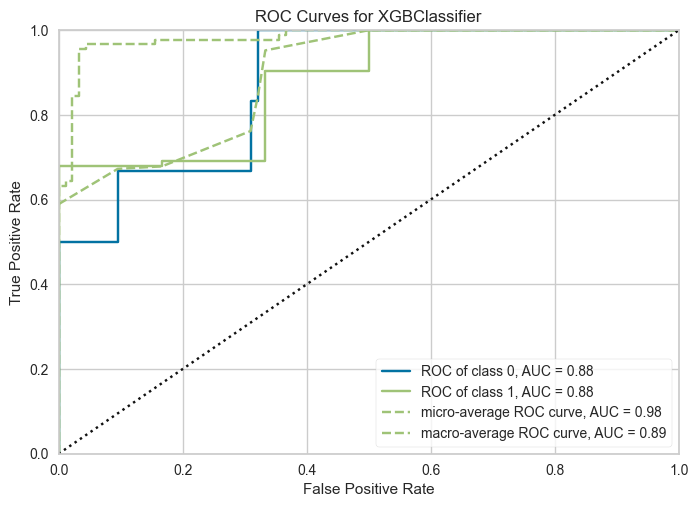

Outer fold 4/5
Configuring PyCaret for outer fold 4
Creating model xgboost for outer fold 4


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9722,0.6857,1.0000,0.9722,0.9859,0.0000,0.0000
1,0.9155,0.6974,1.0000,0.9155,0.9559,0.0000,0.0000
2,0.9718,0.9667,1.0000,0.9706,0.9851,0.7361,0.7631
3,0.9437,0.7425,1.0000,0.9437,0.9710,0.0000,0.0000
4,0.9718,0.8097,1.0000,0.9710,0.9853,0.6537,0.6968
Mean,0.9550,0.7804,1.0000,0.9546,0.9766,0.2779,0.2920
Std,0.0226,0.1028,0.0000,0.0223,0.0118,0.3414,0.3582


Tuning hyperparameters for model xgboost with custom grid


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9722,0.5643,1.0000,0.9722,0.9859,0.0000,0.0000
1,0.9296,0.6974,1.0000,0.9286,0.9630,0.2680,0.3934
2,0.9859,0.9515,1.0000,0.9851,0.9925,0.8815,0.8877
3,0.9437,0.7052,1.0000,0.9437,0.9710,0.0000,0.0000
4,0.9718,0.8060,1.0000,0.9710,0.9853,0.6537,0.6968
Mean,0.9606,0.7449,1.0000,0.9601,0.9795,0.3606,0.3956
Std,0.0207,0.1287,0.0000,0.0208,0.0109,0.3538,0.3594


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Transformation Pipeline and Model Successfully Saved


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9279,0.7267,1.0000,0.9266,0.9619,0.3127,0.4305


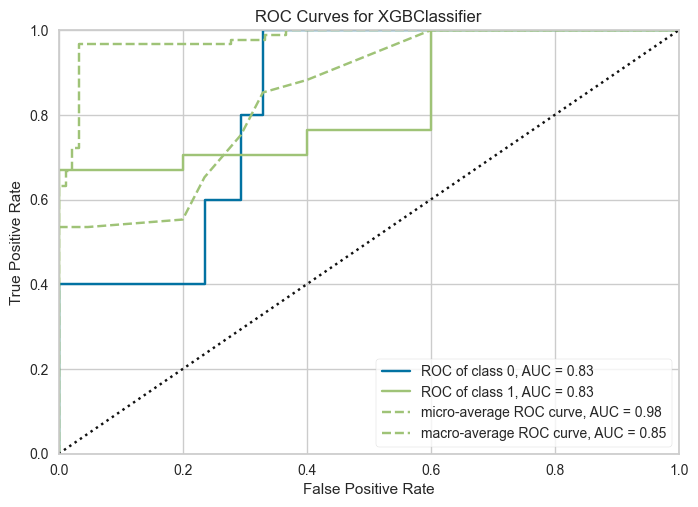

Outer fold 5/5
Configuring PyCaret for outer fold 5
Creating model xgboost for outer fold 5


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9583,0.5459,1.0000,0.9583,0.9787,0.0000,0.0000
1,0.9577,0.8667,1.0000,0.9559,0.9774,0.6468,0.6913
2,0.9296,0.8000,1.0000,0.9296,0.9635,0.0000,0.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.9437,0.7052,1.0000,0.9437,0.9710,0.0000,0.0000
Mean,0.9579,0.7836,1.0000,0.9575,0.9781,0.3294,0.3383
Std,0.0236,0.1527,0.0000,0.0236,0.0122,0.4186,0.4256


Tuning hyperparameters for model xgboost with custom grid


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9722,0.6184,1.0000,0.9718,0.9857,0.4894,0.5692
1,0.9577,0.8846,1.0000,0.9559,0.9774,0.6468,0.6913
2,0.9296,0.8182,1.0000,0.9296,0.9635,0.0000,0.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.9437,0.7090,1.0000,0.9437,0.9710,0.0000,0.0000
Mean,0.9606,0.8060,1.0000,0.9602,0.9795,0.4272,0.4521
Std,0.0243,0.1331,0.0000,0.0243,0.0126,0.3860,0.3949


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Transformation Pipeline and Model Successfully Saved


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9640,0.8070,1.0000,0.9626,0.9810,0.6498,0.6938


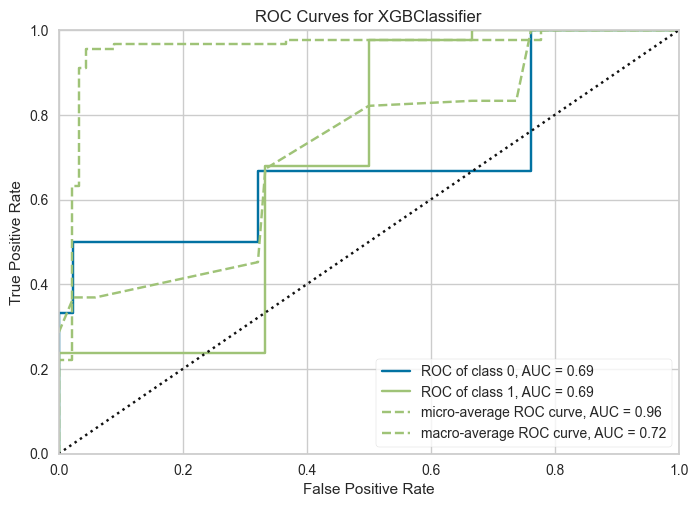

Final metrics table:
     Metric     Mean   Std Dev
0  Accuracy  0.96386  0.007613
1       AUC  0.69022  0.120949
2    Recall  1.00000  0.000000
3     Prec.  0.96342  0.007834
4        F1  0.98136  0.004054
5     Kappa  0.32972  0.189638
6       MCC  0.40742  0.230368


In [8]:
# Initialize the PyCaret Evaluator
evaluator = PyCaretEvaluator(dataset=dataset, target="Fracture", experiment_name="CP_Fracture", filepath="./results/fracture")

# Model training
evaluator.run_experiment(
    train_size=0.8,
    fold=5,
    fold_strategy='kfold',
    outer_fold=5,
    outer_strategy='kfold',
    session_id=42,
    model='xgboost',
    optimize='AUC',
    custom_grid=grid_hps
)